# SPOTLIGHT: Gensim

Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.

# Installation 

Run in your terminal (recommended):

$pip install --upgrade gensim
            
or, alternatively for conda environments:

$conda install -c conda-forge gensim
            

In this notebook I will show the various functionalities of the gensim library on the movie dataset which classifies movies into different genres based on their plot

I initially show tokenization and data preprocessing using the gensim library. Next, I show how the data can be converted to a bag of words corpus. I then show how to implement Word@Vec and find similar words based on their location in the vector space. Later I train the model using KNN and Logistic Regression and implement Doc2Vec. Here the words which relate a plot to a particular genre are shown. Finally I compare LDA and LSI models

In [1]:
import gensim
import pandas as pd

In [2]:
df = pd.read_csv('tagged_plots_movielens.csv')

In [3]:
df

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


# Data Preprocessing

In the code below, the data in the plot column is tokenized by removing stop words, punctuation and other numeric or special characters. This is carried out using the gensim library package. It can also be carried out using the nltk package 

In [4]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import stem_text
from gensim.utils import tokenize

In [5]:
from gensim import corpora
from gensim import matutils

In [6]:
from nltk.tokenize import word_tokenize
my_docs = []
for line in df['plot']:
    my_docs.append(line)
tokenized_docs = [word_tokenize(str(doc).lower()) for doc in my_docs]
custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, remove_stopwords, \
                  strip_multiple_whitespaces, strip_numeric, strip_short]
clean_data = [preprocess_string(" ".join(word), custom_filters) for word in tokenized_docs]
print(clean_data)

[['little', 'boy', 'named', 'andy', 'loves', 'room', 'playing', 'toys', 'especially', 'doll', 'named', 'woody', 'toys', 'andy', 'come', 'life', 'woody', 'believes', 'life', 'toy', 'good', 'worry', 'andy', 'family', 'moving', 'woody', 'know', 'andy', 'birthday', 'party', 'woody', 'realize', 'andy', 'mother', 'gave', 'action', 'figure', 'known', 'buzz', 'lightyear', 'believe', 'toy', 'quickly', 'andy', 'new', 'favorite', 'toy', 'woody', 'consumed', 'jealousy', 'tries', 'rid', 'buzz', 'woody', 'buzz', 'lost', 'way', 'andy', 'moves', 'pass', 'ruthless', 'toy', 'killer', 'sid', 'phillips'], ['kids', 'play', 'magical', 'board', 'game', 'release', 'man', 'trapped', 'decades', 'host', 'dangers', 'stopped', 'finishing', 'game'], ['things', 'change', 'wabasha', 'county', 'max', 'john', 'fighting', 'years', 'grandpa', 'drinks', 'smokes', 'chases', 'women', 'able', 'catch', 'fabled', 'catfish', 'hunter', 'gigantic', 'catfish', 'actually', 'smiles', 'fishermen', 'try', 'snare', 'months', 'ago', 'jo

The words in the list are put in a dictionary and each word has a unique id. This is carried out using the corpora module. Corpora creates a mapping between the word and their integer ids.

In [7]:
from gensim import corpora
# give each word in word list a unique id
dictionary = corpora.Dictionary(clean_data)
# we can get each words' id by token2id
print(dictionary.token2id)



{'action': 0, 'andy': 1, 'believe': 2, 'believes': 3, 'birthday': 4, 'boy': 5, 'buzz': 6, 'come': 7, 'consumed': 8, 'doll': 9, 'especially': 10, 'family': 11, 'favorite': 12, 'figure': 13, 'gave': 14, 'good': 15, 'jealousy': 16, 'killer': 17, 'know': 18, 'known': 19, 'life': 20, 'lightyear': 21, 'little': 22, 'lost': 23, 'loves': 24, 'mother': 25, 'moves': 26, 'moving': 27, 'named': 28, 'new': 29, 'party': 30, 'pass': 31, 'phillips': 32, 'playing': 33, 'quickly': 34, 'realize': 35, 'rid': 36, 'room': 37, 'ruthless': 38, 'sid': 39, 'toy': 40, 'toys': 41, 'tries': 42, 'way': 43, 'woody': 44, 'worry': 45, 'board': 46, 'dangers': 47, 'decades': 48, 'finishing': 49, 'game': 50, 'host': 51, 'kids': 52, 'magical': 53, 'man': 54, 'play': 55, 'release': 56, 'stopped': 57, 'trapped': 58, 'able': 59, 'actually': 60, 'ago': 61, 'ariel': 62, 'bait': 63, 'begin': 64, 'catch': 65, 'catfish': 66, 'change': 67, 'chases': 68, 'claims': 69, 'county': 70, 'drinks': 71, 'fabled': 72, 'fighting': 73, 'fishe

# Bag of Words

The list of words can be converted to a bag of words format(list of (token_id, token_count)) using doc2bow. Each tuple contains the token id and the number of times the token occurs in the document.

In [8]:
new_corpus = [dictionary.doc2bow(text) for text in clean_data]
print(new_corpus)

[[(0, 1), (1, 7), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 2), (42, 1), (43, 1), (44, 6), (45, 1)], [(46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(20, 2), (29, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 3), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1)], [(20, 2), (61, 1), (90, 1), (97, 1), (101, 1), (102, 1), (103, 2), (104, 1)

# Word2Vec

In this section we explore word embeddings using the word2vec module of gemsim. Word embedding enables us to find words similar to a given word.

Word2Vec can be used to represent a word in the vector space. Here, the word 'movie' is represented in the vector space as shown below

In [9]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
model = Word2Vec(clean_data, size=100, window=5, min_count=1, workers=4)


In [10]:
model["movie"]

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.05040601,  0.02114183, -0.03211555, -0.01740699,  0.10877529,
        0.11122718, -0.01300076, -0.0791222 ,  0.08460429,  0.05721042,
        0.03146127, -0.02453438,  0.02472539,  0.06583359, -0.00691432,
        0.07406611, -0.00315801,  0.02266568, -0.09679946,  0.01285999,
        0.04035244,  0.02210116,  0.0176082 , -0.12002226,  0.05447371,
        0.06010246, -0.02496761, -0.12314227,  0.0957786 , -0.05629018,
        0.01940546, -0.05543604,  0.00257468, -0.0696637 , -0.07973281,
        0.01009166,  0.13403602, -0.09497294, -0.02989996,  0.094226  ,
       -0.15080045,  0.0430899 , -0.15265088, -0.04981155,  0.01278991,
       -0.01946278,  0.0214795 , -0.03182869, -0.02747249, -0.05668614,
        0.00878595,  0.01492966, -0.08093023,  0.03754537, -0.01685364,
       -0.14549094,  0.04557614,  0.13531521, -0.03071168,  0.04326827,
       -0.07737686, -0.01820726, -0.02719069,  0.00540428, -0.08616511,
       -0.05284246, -0.00521162,  0.12493484,  0.02643284, -0.01

The trained Word2Vec model can be used to find words similar to a particular word. This is done by finding words with similar meaning which are located near the word in the vector space. As you can see none of the words shown below are similar to the word movie. This is because the model is not sufficiently trained. 

In [11]:
w1 = "movie"
model.wv.most_similar(positive=w1, topn=10)

[('finds', 0.9988934993743896),
 ('man', 0.9987662434577942),
 ('earth', 0.9986962080001831),
 ('years', 0.9986900091171265),
 ('lives', 0.9986879229545593),
 ('soon', 0.9986810684204102),
 ('son', 0.9986552000045776),
 ('life', 0.9986468553543091),
 ('way', 0.9986286759376526),
 ('help', 0.9986268281936646)]

# Doc2Vec

Doc2Vec which is similar to Word2Vec can be used for document classification. It introduces 'a tag' - a word that is in every context in the document.
For our first try we tag every plot with its genre. This makes it 'semi-supervised' learning i.e the genre is not the only thing determining prediction. The words in the plot also are required and one word can occur in multiple genres.
The data is split into train and test data and the data is tokenized.

In [12]:
import sklearn
from sklearn.model_selection import train_test_split

In [13]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [14]:
test_data.iloc()[56]['plot']

"A group of old friends have a tradition of going to a public bathing house on New Years eve. Occasionally too much vodka and beer makes two of them unconscious. The problem is that one of them (Sasha) has to go to Leningrad but another one (Zhenya) goes. Zhenya wakes up at Leningrad airport. Believing that he is still in Moscow he takes a taxi and goes home. The street name, building and even apartment number, the way an apartment complex looks the same and the key coincide completely - just typical Soviet-type 'economy' architecture. Imagine the surprise of Nadya when she enters her apartment and finds a man without trousers in her bed. What's more - Nadya's fianc also finds him there..."

In [15]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk

In [16]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(str(text)):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [17]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [18]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [19]:
test_tagged.values[50]

TaggedDocument(words=['divorced', 'woman', 'and', 'her', 'diabetic', 'daughter', 'take', 'refuge', 'in', 'their', 'newly-purchased', 'house', "'s", 'safe', 'room', 'when', 'three', 'men', 'break-in', 'searching', 'for', 'missing', 'fortune'], tags=['action'])

Doc2Vec is a Model that represents each Document as a Vector. This is similar to Word2Vec except the doc has an additional paragraph id apart from the word vectors which also contribute to all training predictions.

In [20]:
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


An additional requirement for doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs

In [21]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

Both logistic regression and KNN is implemented to train the model and find similar words to each genre. The accuracy of prediction while using logistic regression is higher than the accuracy while using KNN. The confusion matrix is also plotted in each case.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [23]:
my_tags = df.tag.unique()

In [24]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4857142857142857
confusion matrix
 [[ 6  2 18  2  3  4]
 [ 4  4  7  1  1  0]
 [ 1  0 59  8 14  1]
 [ 0  2 13 26  1  4]
 [ 0  2 17  4  8  1]
 [ 0  2  7  4  3 16]]
(row=expected, col=predicted)


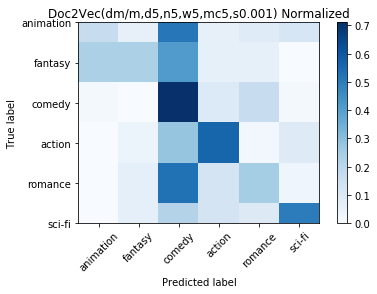

In [26]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

accuracy 0.3306122448979592
confusion matrix
 [[11  1  2  0 10 11]
 [ 2  1  3  0  6  5]
 [ 2  0 17  2 51 11]
 [ 0  0  1 10  7 28]
 [ 2  2  6  2 18  2]
 [ 1  1  1  1  4 24]]
(row=expected, col=predicted)


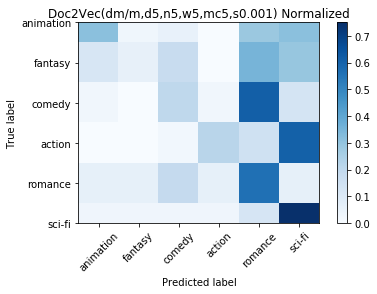

In [27]:
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Now we can find accurate similarities between words in the dataset. When we look for genres similar to action we find comedy has some similar aspects to action but romance is in no way related to action and hence the negative value

In [28]:
doc2vec_model.docvecs.most_similar('action')

[('sci-fi', 0.7076687812805176),
 ('romance', 0.3541388213634491),
 ('comedy', 0.315315842628479),
 ('fantasy', 0.14930137991905212),
 ('animation', -0.1069665253162384)]

Similarly the words most likely to occur in the plot for each genre is shown below. 
For example, most scifi movies will have the word 'alien' in its plot

In [29]:
doc2vec_model.most_similar([doc2vec_model.docvecs['sci-fi']])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('weapon', 0.9851616024971008),
 ('nuclear', 0.9845601916313171),
 ('supply', 0.9837321639060974),
 ('collect', 0.9812847971916199),
 ('ship', 0.9799367189407349),
 ('alien', 0.979867160320282),
 ('forces', 0.9797414541244507),
 ('mount', 0.9793685674667358),
 ('planet', 0.9789683818817139),
 ('race', 0.9774630665779114)]

In [30]:
doc2vec_model.most_similar([doc2vec_model.docvecs['comedy']])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dorothy', 0.9738483428955078),
 ('manager', 0.9637553691864014),
 ('your', 0.951227068901062),
 ('commandant', 0.9391495585441589),
 ('bob', 0.9384275674819946),
 ('strip', 0.9334663152694702),
 ('sending', 0.9315885305404663),
 ('lazy', 0.9296203851699829),
 ('teams', 0.9293302893638611),
 ('up', 0.9246268272399902)]

In [31]:
doc2vec_model.most_similar([doc2vec_model.docvecs['action']])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('secret', 0.976102888584137),
 ('agent', 0.9694103002548218),
 ('boston', 0.9653218388557434),
 ('connor', 0.9578690528869629),
 ('dealer', 0.9534019231796265),
 ('arts', 0.9449509382247925),
 ('fbi', 0.9401460886001587),
 ('serial', 0.9339085817337036),
 ('espionage', 0.9336334466934204),
 ('ripper', 0.9333723783493042)]

In [32]:
doc2vec_model.most_similar([doc2vec_model.docvecs['romance']])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('older', 0.9939103126525879),
 ('ex-boyfriend', 0.9884011149406433),
 ('jan', 0.9872177243232727),
 ('carl', 0.9871606230735779),
 ("'s", 0.9869071245193481),
 ('wife', 0.9848922491073608),
 ('ransom', 0.9840856790542603),
 ('meets', 0.9838687181472778),
 ('tells', 0.9836081266403198),
 ('develops', 0.9807382822036743)]

In [33]:
doc2vec_model.most_similar([doc2vec_model.docvecs['fantasy']])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('queen', 0.9761333465576172),
 ('frozen', 0.9690966606140137),
 ('merlin', 0.9494441151618958),
 ('king', 0.9468064308166504),
 ('longs', 0.9444561004638672),
 ('amish', 0.9383828043937683),
 ('princess', 0.9376204609870911),
 ('allen', 0.9243491888046265),
 ('immortality', 0.9216521382331848),
 ('throne', 0.9202122092247009)]

In [34]:
doc2vec_model.most_similar([doc2vec_model.docvecs['animation']])

/Users/anusha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('janeiro', 0.949131965637207),
 ('kingdom', 0.9326701164245605),
 ('heir', 0.930509626865387),
 ('through', 0.9295167922973633),
 ('slacker', 0.9291213154792786),
 ('whoville', 0.9197229743003845),
 ('into', 0.9128861427307129),
 ('models', 0.9107524752616882),
 ('elves', 0.9072737097740173),
 ('their', 0.9017235636711121)]

# LDA vs LSI models

In the last section we are comparing LDA and LSI models. These are models similar to neural networks where the data is trained and each word is assigned weights for a particular topic. 


The tokenized data is converted to a corpus using doc2bow.. LDA and LSI are run on this corpus

Evaluation is done by finding perplexity and coherance. Perplexity cannot be calculated on an LSI model. 

Perplexity is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

Coherence measure scores a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

Low perplexity and high coherance indicates a better model

In [37]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(clean_data)

#remove extremes 
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in clean_data]

In [40]:
%time lda = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)


CPU times: user 2min 49s, sys: 980 ms, total: 2min 50s
Wall time: 2min 56s


In [41]:
lda.show_topics()

[(0,
  '0.006*"life" + 0.005*"new" + 0.004*"man" + 0.003*"help" + 0.003*"world" + 0.003*"finds" + 0.002*"time" + 0.002*"father" + 0.002*"school" + 0.002*"day"'),
 (1,
  '0.005*"life" + 0.005*"young" + 0.004*"world" + 0.004*"man" + 0.004*"new" + 0.004*"love" + 0.003*"earth" + 0.003*"war" + 0.003*"help" + 0.003*"family"'),
 (2,
  '0.005*"young" + 0.005*"life" + 0.004*"woman" + 0.004*"new" + 0.004*"man" + 0.003*"family" + 0.003*"love" + 0.003*"father" + 0.003*"home" + 0.003*"day"'),
 (3,
  '0.005*"life" + 0.004*"new" + 0.004*"world" + 0.004*"father" + 0.003*"time" + 0.003*"love" + 0.003*"finds" + 0.003*"young" + 0.003*"man" + 0.003*"friends"'),
 (4,
  '0.005*"world" + 0.005*"man" + 0.005*"new" + 0.005*"life" + 0.004*"love" + 0.004*"time" + 0.003*"young" + 0.003*"family" + 0.003*"way" + 0.003*"story"')]

In [44]:

from gensim.models import CoherenceModel

print('Perplexity: ', lda.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda, texts=clean_data, dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -9.054336119268893
Coherence Score:  0.3240132792812591


In [45]:
lsi = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=5, onepass=False, power_iters=10)

In [47]:
lsi.show_topics()

[(0,
  '0.344*"life" + 0.228*"new" + 0.211*"love" + 0.198*"man" + 0.178*"world" + 0.168*"young" + 0.154*"father" + 0.141*"time" + 0.125*"family" + 0.119*"years"'),
 (1,
  '0.480*"jack" + -0.370*"life" + 0.327*"man" + 0.314*"reggie" + -0.196*"love" + 0.149*"ice" + 0.149*"help" + 0.128*"earth" + 0.114*"world" + 0.111*"brock"'),
 (2,
  '0.420*"life" + 0.333*"jack" + -0.256*"new" + 0.254*"man" + -0.250*"earth" + 0.238*"reggie" + -0.199*"world" + -0.113*"planet" + -0.109*"alien" + 0.100*"love"'),
 (3,
  '-0.543*"love" + 0.459*"life" + -0.391*"young" + -0.167*"woman" + 0.146*"new" + -0.120*"man" + -0.115*"falls" + 0.106*"earth" + -0.102*"valjean" + -0.070*"girl"'),
 (4,
  '-0.451*"new" + 0.423*"earth" + -0.398*"world" + 0.173*"planet" + 0.158*"kirk" + 0.148*"spock" + 0.126*"alien" + -0.119*"york" + 0.115*"years" + 0.113*"ship"')]

In [50]:

coherence_model_lsi = CoherenceModel(model=lsi, texts=clean_data, dictionary=dictionary)

coherence_lsi = coherence_model_lsi.get_coherence()
print('Coherence Score: ', coherence_lsi)

Coherence Score:  0.3111532286713884


In the above example LDA performs better than LSI